# Neural Networks

Numerous advances of machine learning, especially in image, voice recognition, natural language processing nowadays rely on neural networks. Networks with multiple hidden layers are often referred to as "deep" leading to a concept of deep learning.

The concept was out there for decades but pathway was not streighforward - initial inspiration and anticipation challenged first by computational complexity making it difficult to implement any non-trivial architectures needed to overcome perfomance of more traditional machine learning tools, then vanishing gradient problem challenging our ability to train deep networks. Now when technology and computing power match the needs of real-world problems, we evidence a huge trend in deep learning applications.

Populating the interactive namespace from numpy and matplotlib


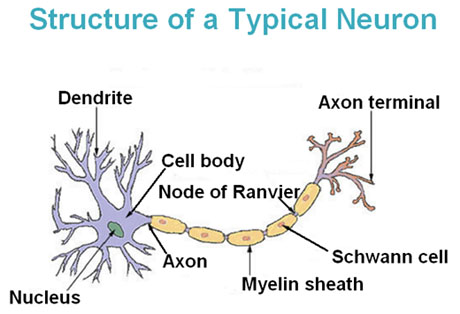

In [1]:
#origin of the idea
%pylab inline
from PIL import Image
import urllib.request as url
import io
fd = url.urlopen("https://upload.wikimedia.org/wikipedia/commons/b/bd/Neuron.jpg")
image_file = io.BytesIO(fd.read())
Image.open(image_file)

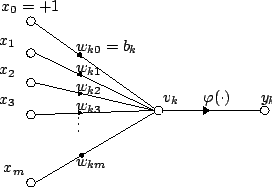

In [2]:
#scheme of the artificial neuron
fd = url.urlopen("https://upload.wikimedia.org/wikipedia/commons/b/b0/Artificial_neuron.png")
image_file = io.BytesIO(fd.read())
Image.open(image_file)

A classic artificial neuron is a logit classifier:
$$
y=\sigma\left(\sum_i w_i x_i+w_0\right),
$$
where $x_i$ are the input signals ranging from zero to one, $w_i$ are the weights to learn, $y$ is the output and $\sigma$ stands for sigmoid function, ensuring the output $y$ also falls within a $[0,1]$ range.

A classic neural network is a layered pool of those logit classifiers: first (hidden) layer of neurons transformes input data (often represented as an input layer of the network) into intitial outputs, second (hidden) layer takes outputs from the first layer transforming them further etc until the final layers produces the final set of outputs (output layer) also taking previous layer's outputs as inputs.

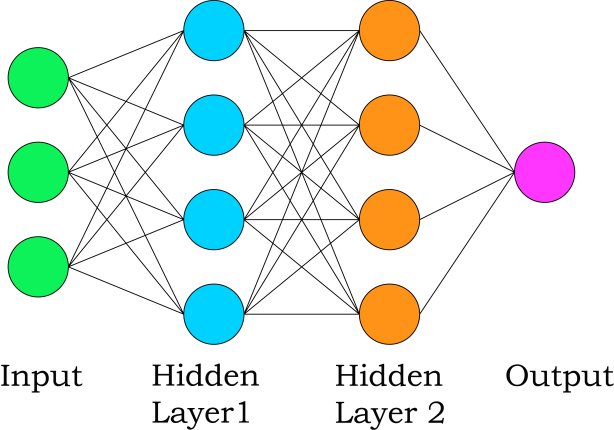

In [3]:
#scheme of the neural network
fd = url.urlopen("https://en.mlab.ai/sites/default/files/inline-images/neural1_1.jpg")
image_file = io.BytesIO(fd.read())
Image.open(image_file)

A fundamental difference from just a bunch of classic logistic regressions is that all the neurons (specifically their weights $w_i$) are trained together, rather than one by one. This is acheived through a backpropagation algorithm, computing gradient of the objective function (e.g. cumulative square error between acheived and given outputs) in the space of all the coefficients that need to be trained, using an iterative procedure based on a chain rule for computing derivatives of the composition of functions. It starts with the last hidden layers computing the derivatives of the outputs with respect to the coefficients of its neurons as well as their inputs, being the outputs of the previous layer and keeps to iteratively propagate the derivative computation to further neuron coefficients and the outputs of the prior layers until the first layer is reached, while its inputs are constants given input data observation and no further derivatives are needed. Then gradient descent methods enable optimization of the objective function with respect to all the network weights at once by iteratively adjusting those in the direction of the gradient.

In [1]:
# Load the libraries.

%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt  
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
import pymc3 as pm
import theano
from mpl_toolkits.mplot3d import Axes3D
#import fix_yahoo_finance as yf
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.datasets import mnist

%matplotlib inline

In [5]:
#generate random data x1,x2 and a target variable y(label) implementing logical xor
np.random.seed(2019)
n=10000
x1 = np.random.randint(0, 2, n)
x2 = np.random.randint(0, 2, n)
y = 1.0*(x1!=x2) #np.logical_xor
data = pd.DataFrame({'y':y, 'x1':x1, 'x2':x2})
data.head(7)

,y,x1,x2
0,1.0,0,1
1,1.0,0,1
2,0.0,1,1
3,1.0,1,0
4,1.0,0,1
5,0.0,0,0
6,0.0,0,0


In [6]:
train, test = train_test_split(data, test_size = 0.2, random_state = 1)

In [7]:
mod = smf.ols(formula='y ~ x1 + x2', data = train).fit()
print(mod.summary())
test['lm_predicr'] = mod.predict(test)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.02025
Date:                Fri, 13 Dec 2019   Prob (F-statistic):              0.980
Time:                        21:27:08   Log-Likelihood:                -5806.2
No. Observations:                8000   AIC:                         1.162e+04
Df Residuals:                    7997   BIC:                         1.164e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5040      0.010     51.906      0.0

In [8]:
mod = smf.logit(formula='y ~ x1 + x2', data = train).fit()
print(mod.summary())
test['logit_predict'] = mod.predict(test)

Optimization terminated successfully.
         Current function value: 0.693128
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7997
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Dec 2019   Pseudo R-squ.:               3.653e-06
Time:                        21:27:08   Log-Likelihood:                -5545.0
converged:                       True   LL-Null:                       -5545.0
Covariance Type:            nonrobust   LLR p-value:                    0.9800
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0161      0.039      0.413      0.679      -0.060       0.092
x1            -0.0001      0.

In [9]:
test.head(10)

,y,x1,x2,lm_predicr,logit_predict
9953,0.0,0,0,0.504013,0.504013
3850,0.0,1,1,0.501737,0.501737
4962,0.0,1,1,0.501737,0.501737
3886,1.0,0,1,0.501763,0.501763
5437,0.0,0,0,0.504013,0.504013
8517,1.0,1,0,0.503987,0.503987
2041,1.0,1,0,0.503987,0.503987
1989,1.0,0,1,0.501763,0.501763
1933,0.0,0,0,0.504013,0.504013
9984,0.0,0,0,0.504013,0.504013


In [10]:
#Test accuracy
1.0*sum((test['y']==1)==(test['logit_predict']>=0.5))/len(test['y'])

0.5215

In [11]:
#but actually this is because regression never predicts 0!
test['logit_predict'].max()

0.504013041159711

In [12]:
#try an alternative decision boundary
dec_tres=mod.predict(train).mean(); dec_tres

0.5028750000000148

In [13]:
#Test accuracy - not much improved
1.0*sum((test['y']==1)==(test['logit_predict']>=dec_tres))/len(test['y'])

0.508

In [14]:
#prepare data for out first neural network
X_train = train[['x1', 'x2']].values
y_train = train['y'].values
X_test = test[['x1', 'x2']].values
y_test = test['y'].values
dim = X_train.shape[1]

#### Notes
* Binary cross-entropy objective function
$$
L(y,\hat{y})=-\frac{1}{N}\sum\limits_0^N\left(y_i log(\hat{y}_i)+(1-y_i)log(1-\hat{y}_i)\right)
$$
Start with five perceptrons and evaluate the performance using the MSE metric.
* Try different numbers of perceptrons.
* Try different numbers of hidden layers.
* Try different activation functions
* Try mean least square error objective function
* What's 'relu'?  It is the rectified linear activation unit.  Piecewise linear representation of the logit:
$$
relu(x)=\max(0,x)
$$

In [15]:
np.random.seed(2019)
model = Sequential()
model.add(Dense(5, activation='relu', input_dim=dim))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=2)
test['dl_predict'] = model.predict(X_test)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8000 samples, validate on 2000 samples
Epoch 1/20





 - 1s - loss: 0.7009 - acc: 0.2554 - val_loss: 0.6958 - val_acc: 0.2395
Epoch 2/20
 - 0s - loss: 0.6907 - acc: 0.3988 - val_loss: 0.6870 - val_acc: 0.5080
Epoch 3/20
 - 0s - loss: 0.6846 - acc: 0.6392 - val_loss: 0.6813 - val_acc: 0.7610
Epoch 4/20
 - 0s - loss: 0.6793 - acc: 0.7520 - val_loss: 0.6757 - val_acc: 0.7610
Epoch 5/20
 - 0s - loss: 0.6733 - acc: 0.7520 - val_loss: 0.6686 - val_acc: 0.7610
Epoch 6/20
 - 0s - loss: 0.6655 - acc: 0.7520 - val_loss: 0.6602 - val_acc: 0.7610
Epoch 7/20
 - 0s - loss: 0.6563 - acc: 0.7520 - val_loss: 0.6501 - val_acc: 0.7610
Epoch 8/20
 - 0s - loss: 0.6455 - acc: 0.7520 - val_loss: 0.6385 - val_acc: 0.7610
Epoch 9/20
 - 0s - loss: 0.6331 - acc: 0.9527 - val_loss: 0.6255 - val_acc: 1.0000
Epoch 10/20
 - 0s - loss: 0.6194 - acc: 1.0000 - val_loss: 0.6112 - val_acc: 1.0000
Epoch 11/20
 -

In [16]:
print("The MSE is %f" % mean_squared_error(test['y'], test['dl_predict']))

The MSE is 0.146130


In [17]:
test['dl_label']=1.0*(test['dl_predict']>0.5)

In [18]:
#Test accuracy
1.0*sum((test['y']==1)==(test['dl_predict']>0.5))/len(test['dl_predict'])

1.0

In [19]:
print(test.head(20))

        y  x1  x2  lm_predicr  logit_predict  dl_predict  dl_label
9953  0.0   0   0    0.504013       0.504013    0.455674       0.0
3850  0.0   1   1    0.501737       0.501737    0.325061       0.0
4962  0.0   1   1    0.501737       0.501737    0.325061       0.0
3886  1.0   0   1    0.501763       0.501763    0.727182       1.0
5437  0.0   0   0    0.504013       0.504013    0.455674       0.0
8517  1.0   1   0    0.503987       0.503987    0.558371       1.0
2041  1.0   1   0    0.503987       0.503987    0.558371       1.0
1989  1.0   0   1    0.501763       0.501763    0.727182       1.0
1933  0.0   0   0    0.504013       0.504013    0.455674       0.0
9984  0.0   0   0    0.504013       0.504013    0.455674       0.0
8418  1.0   1   0    0.503987       0.503987    0.558371       1.0
2418  0.0   0   0    0.504013       0.504013    0.455674       0.0
6811  1.0   0   1    0.501763       0.501763    0.727182       1.0
1217  1.0   0   1    0.501763       0.501763    0.727182      

## Case: Hand-written digit recognition

Import the LeCun et al. MNIST dataset of handwritten characters

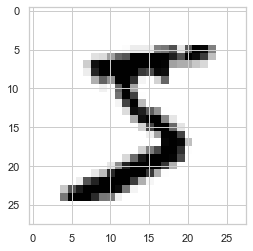

Training label(s): [5]


In [20]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

num_digits = 1
for i in range(num_digits):
    plt.subplot(1, num_digits, i+1)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray_r'))
#    plt.axis('off')
plt.show()
print('Training label(s): %s' % (y_train[0:num_digits],))

In [21]:
X_train.shape

(60000, 28, 28)

In [22]:
y_train.shape

(60000,)

In [23]:
y_train[0]

5

In [24]:
X_train[0,10:20,10:20]

array([[  1, 154, 253,  90,   0,   0,   0,   0,   0,   0],
       [  0, 139, 253, 190,   2,   0,   0,   0,   0,   0],
       [  0,  11, 190, 253,  70,   0,   0,   0,   0,   0],
       [  0,   0,  35, 241, 225, 160, 108,   1,   0,   0],
       [  0,   0,   0,  81, 240, 253, 253, 119,  25,   0],
       [  0,   0,   0,   0,  45, 186, 253, 253, 150,  27],
       [  0,   0,   0,   0,   0,  16,  93, 252, 253, 187],
       [  0,   0,   0,   0,   0,   0,   0, 249, 253, 249],
       [  0,   0,   0,   0,  46, 130, 183, 253, 253, 207],
       [  0,   0,  39, 148, 229, 253, 253, 253, 250, 182]], dtype=uint8)

### These are grey scale images that can be converted to dataframes
* The darker the pixel, the larger the value in the cell.  
* The data is 28 X 28 pixel grids of 0-255 grey scale

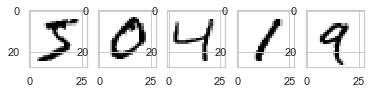

Training labels: [5 0 4 1 9]


In [25]:
num_digits = 5
for i in range(num_digits):
    plt.subplot(1, num_digits, i+1)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray_r'))
#    plt.axis('off')
plt.show()
print('Training labels: %s' % (y_train[0:num_digits],))

In [26]:
# Preprocess the NMIST data, which are stored as 28 X 28 pixels of grayscale between 1 and 255.

num_pixels = X_train.shape[1] * X_train.shape[2]
X_train_pp = (X_train.reshape(X_train.shape[0], num_pixels).astype('float32')) / 255
X_test_pp = (X_test.reshape(X_test.shape[0], num_pixels).astype('float32')) / 255

In [27]:
# Keras needs the labels as categorical matrics.

y_train_pp = np_utils.to_categorical(y_train)
y_test_pp = np_utils.to_categorical(y_test)
num_classes = y_test_pp.shape[1]

In [28]:
y_test[0]

7

In [29]:
28**2

784

In [30]:
y_test_pp[0,:]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [31]:
# Define a simple MLP with three hidden layers of 150, 300, and 150 neurons, respectively.
# First line of code: set a seed for replication.
# Second: Define the model to be sequential using Keras.
# Next three lines: 
    # Define the MLP, where number units sets the number of neurons
    # input_dim is the dimension of the data flowing in and passing through the layers.  It remains fixed.
    # activation is the sigmoidal shape of a neuron, here using the rectified linear unit or 'relu'
# Final line: 
    # We map into the number of classes we have for the digits with the softmax activation, which just chooses
    # the most probable.
    #use soft-max activation: https://en.wikipedia.org/wiki/Softmax_function

np.random.seed(2019)
model = Sequential()
model.add(Dense(units=300, input_dim=num_pixels, activation='relu'))
model.add(Dense(units=150, activation='relu'))
model.add(Dense(units=150, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

# Compile, fit, and generate scores and predicted probabilities.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.fit(X_train_pp, y_train_pp, validation_data=(X_test_pp, y_test_pp), epochs=10, batch_size=200, verbose=2)
scores = model.evaluate(X_test_pp, y_test_pp, verbose=0)
prob = model.predict(X_test_pp)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 6s - loss: 0.3212 - categorical_accuracy: 0.9054 - val_loss: 0.1436 - val_categorical_accuracy: 0.9541
Epoch 2/10
 - 4s - loss: 0.1110 - categorical_accuracy: 0.9668 - val_loss: 0.1100 - val_categorical_accuracy: 0.9658
Epoch 3/10
 - 4s - loss: 0.0759 - categorical_accuracy: 0.9768 - val_loss: 0.0962 - val_categorical_accuracy: 0.9692
Epoch 4/10
 - 4s - loss: 0.0535 - categorical_accuracy: 0.9832 - val_loss: 0.0830 - val_categorical_accuracy: 0.9728
Epoch 5/10
 - 4s - loss: 0.0382 - categorical_accuracy: 0.9877 - val_loss: 0.0863 - val_categorical_accuracy: 0.9756
Epoch 6/10
 - 4s - loss: 0.0365 - categorical_accuracy: 0.9882 - val_loss: 0.0719 - val_categorical_accuracy: 0.9800
Epoch 7/10
 - 4s - loss: 0.0300 - categorical_accuracy: 0.9905 - val_loss: 0.0878 - val_categorical_accuracy: 0.9763
Epoch 8/10
 - 3s - loss: 0.0229 - categorical_accuracy: 0.9926 - val_loss: 0.0688 - val_categorical_accuracy: 0.9804
Epoch 9/10
 - 

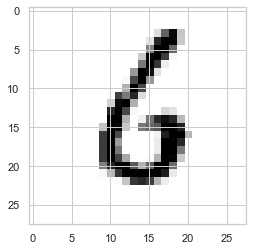

Classified as a 6 with probability 0.999809


In [32]:
# Examine the performance of the 50th image in the test set.

img = 50
plt.imshow(X_test[img], cmap=plt.get_cmap('gray_r'))
#plt.axis('off')
plt.show()
print('Classified as a %d with probability %f' % (prob[img].argmax(), max(prob[img])))

In [33]:
# Standard measures of performance.
# First the accuracy rate on the test or validation set.

from sklearn.metrics import accuracy_score
print('Accuracy Rate: %f' % accuracy_score(y_test, prob.argmax(axis = 1)))

Accuracy Rate: 0.980100


In [34]:
# Next the confusion matrix, which shows correct and incorrect classification on the test set.

from sklearn.metrics import confusion_matrix
print('Confusion matrix:\n%s' % confusion_matrix(y_test, prob.argmax(axis = 1)))

Confusion matrix:
[[ 972    1    3    1    0    0    1    1    1    0]
 [   0 1123    4    1    0    1    2    1    3    0]
 [   2    0 1024    0    1    0    1    2    2    0]
 [   0    0    6  989    0    4    0    3    6    2]
 [   1    1    3    1  960    0    4    1    3    8]
 [   2    0    0    7    1  874    2    0    5    1]
 [   3    2    0    1    2    5  944    0    1    0]
 [   1    2   16    1    2    0    0  999    2    5]
 [   1    0    8    7    1    3    1    2  950    1]
 [   6    2    2    9    8    3    0    3   10  966]]


In [35]:
# Next a classification report.

from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(y_test, prob.argmax(axis = 1)))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.99      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.97      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [36]:
# Finally, identify cases that failed.

errors=(y_test - prob.argmax(axis = 1) > 0).nonzero()[0]; errors

array([ 104,  151,  259,  274,  340,  445,  448,  495,  582,  810,  951,
        965,  982, 1014, 1039, 1178, 1226, 1232, 1247, 1299, 1319, 1393,
       1414, 1429, 1441, 1530, 1553, 1671, 1751, 1754, 1850, 1878, 1901,
       1941, 1952, 1982, 2004, 2016, 2028, 2098, 2129, 2135, 2293, 2325,
       2387, 2406, 2414, 2582, 2597, 2607, 2648, 2654, 2758, 2760, 2810,
       2896, 2921, 2927, 2939, 3005, 3023, 3060, 3422, 3503, 3520, 3549,
       3558, 3597, 3853, 3941, 3951, 3985, 4000, 4078, 4123, 4140, 4163,
       4224, 4321, 4344, 4369, 4433, 4443, 4497, 4534, 4536, 4551, 4671,
       4690, 4761, 4807, 4823, 4837, 4956, 4990, 5246, 5495, 5676, 5745,
       5887, 5937, 5972, 6071, 6157, 6166, 6172, 6173, 6560, 6784, 6826,
       6847, 7268, 7823, 8408, 9009, 9015, 9019, 9024, 9280, 9587, 9679,
       9745, 9770, 9792, 9904])

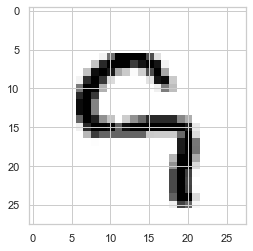

Classified as a 5 with probability 0.774100


In [37]:
img = errors[0]
plt.imshow(X_test[img], cmap=plt.get_cmap('gray_r'))
#plt.axis('off')
plt.show()
print('Classified as a %d with probability %f' % (prob[img].argmax(), max(prob[img])))

In [38]:
y_test[img]

9